#### 사용자 정의 데이터셋과 모델과 학습
- iris.csv => 사용자 정의 데이터셋
- DNN 모델 ==> 사용자 정의 보델

[1] 모듈 로딩 및 데이터 준비

In [45]:
# 모듈 로딩
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optimizer
from torchmetrics.classification import F1Score
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
import pandas as pd


In [46]:
# 데이터
FILE_PATH = 'iris.csv'


In [47]:
# csv => DataFrmae
irisDF = pd.read_csv(FILE_PATH)
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa


In [48]:
# 타겟 컬럼 수치화 == > LabelEncoder
from sklearn.preprocessing import LabelEncoder      # 타겟 컬럼 수치화

In [49]:
lb = LabelEncoder()
lb.fit(irisDF['variety'])
irisDF['variety']=lb.transform(irisDF['variety'])

[2] 사용자 정의 데이터셋 클래스 생성

In [50]:
# 클래스 목적 : 학습용 데이터셋 텐서화 및 전처리
# 클래스 이름 : customDataSet
# 부모클래스 : torch.utils.data.Dataset
# 매개 변수: featureDF, targetDF

In [51]:
class CustomDataset(Dataset):
    # 데이터 로딩 및 전처리 진행과 인스턴스 생성 메서드
    def __init__(self, featureDF, targetDF):
        super().__init__()
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_feaures=featureDF.shape[1]

    # 데이터의 개수 반환 메서드
    def __len__(self) :
        return self.n_rows

    
    # 특정 index의 데이터와 타겟 반환 메서드 => Tensor 반환!!!
    def __getitem__(self, idx) :
        featureTS=torch.FloatTensor( self.featureDF.iloc[idx].values)
        targetTS=torch.FloatTensor( self.targetDF.iloc[idx].values)
        return featureTS, targetTS

[3] 데이터셋 인스턴스 생성

In [52]:
featureDF = irisDF[irisDF.columns[:-1]]
targetDF = irisDF[[irisDF.columns[-1]]]

print(f'featureDF => {featureDF.shape}, targetDF => {targetDF.shape}')

featureDF => (150, 4), targetDF => (150, 1)


In [53]:
from sklearn.model_selection import train_test_split

In [54]:
# 학습, 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size=0.2, random_state=42)

In [55]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

[4] 데이터로더 인스턴스 생성

In [56]:
## 필요한 것 : Dataset 인스턴스, Batch_size=1 기본값
train_DL=DataLoader(train_dataset, batch_size=10)
test_DL=DataLoader(test_dataset, batch_size=10)

In [57]:
for dataTS, targetTS in train_DL:
    print(dataTS.shape, targetTS.shape)
    break

torch.Size([10, 4]) torch.Size([10, 1])


[5] 모델 생성

In [58]:
# ---------------------------------------------------------
# 모델 이름 : CustomModel
# 부모클래스 : nn.Module
# 매개 변수 : None
# 모델구조
# -입력층 : 입력 4개    출력 10개   AF ReLU
# -은닉층 : 입력 10개   출력 30개   AF ReLU -> LeakyReLU
# -출력층 : 입력 30개   출력 3개    AF 분류 - 다중 softmax  0,1,2
# ---------------------------------------------------------
class CustomModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.in_layer=nn.Linear(4, 10) #입력층
        self.h_layer=nn.Linear(10,30)  #은닉층
        self.out_layer=nn.Linear(30,3) #출력층
    
    def forward(self, x):            
        y=F.relu(self.in_layer(x))
        y=F.relu(self.h_layer(y))
        return self.out_layer(y)

In [59]:
### 모델 인스턴스 생성
model = CustomModel()
print(model)
summary(model, input_size=(1000,4))

CustomModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (h_layer): Linear(in_features=10, out_features=30, bias=True)
  (out_layer): Linear(in_features=30, out_features=3, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
CustomModel                              [1000, 3]                 --
├─Linear: 1-1                            [1000, 10]                50
├─Linear: 1-2                            [1000, 30]                330
├─Linear: 1-3                            [1000, 3]                 93
Total params: 473
Trainable params: 473
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.47
Input size (MB): 0.02
Forward/backward pass size (MB): 0.34
Params size (MB): 0.00
Estimated Total Size (MB): 0.36

[6] 학습

In [60]:
adam_optim=optimizer.Adam(model.parameters(), lr=0.01)

In [61]:
# ## 배치크기만큼 데이터와 타겟 추출해서 학습 진행
# TS_loss, TS_score=[[]], [[]]
# for epoch in range(100): # 에포크 100 설정
#     loss_total, score_total = 0,0
#     for dataTS, targetTS in irisDL:
#         # 배치크기 만큼의 학습 데이터
#         #print(dataTS.shape, targetTS.shape, targetTS.dtype)
#         targetTS = targetTS.reshape(-1).long()

#         #배치크기만큼 학습 진행
#         pre_y = model(dataTS)
#         #print(pre_y.shape, targetTS.reshape(-1).shape)

#         # 손실 계산
#         loss=nn.CrossEntropyLoss()(pre_y, targetTS)  # 클래스라이렇게함
#         loss_total += loss.item()
        
#         score=F1Score(task='multiclass',num_classes=3, average='macro')(pre_y, targetTS)
#         score_total += score.item()

#         # 최적화 
#         adam_optim.zero_grad()
#         loss.backward()
#         adam_optim.step()

#     # 에포크단위 손실, 성능지표
#     TS_loss[0].append(loss_total/irisDL.batch_size)  # 배치의 평균
#     TS_score[0].append(score_total/irisDL.batch_size)

#     # 학습결과 출력
#     print(f'[{epoch}//100]')
#     print(f'-Train LOSS : {TS_loss[0][-1]} F1Score : {TS_score[0][-1]}')


In [62]:
# traing 함수
def training(model, dataloader, test_DL, optimizer, epochs=100):
    TS_loss, TS_score =[[],[]], [[],[]]

    for epoch in range(epochs):
        loss_total, score_total = 0, 0

        for dataTS, targetTS in dataloader:
            targetTS = targetTS.reshape(-1).long()
            pre_y = model(dataTS)
        
            loss=nn.CrossEntropyLoss()(pre_y, targetTS)  # 클래스라이렇게함
            loss_total += loss.item()

            score=F1Score(task='multiclass',num_classes=3, average='macro')(pre_y, targetTS)
            score_total += score.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        TS_loss[0].append(loss_total/len(dataloader))  # 배치의 평균
        TS_score[0].append(score_total/len(dataloader))

        #테스트를 검증으로 쓰기
        val_loss, val_score = testing(model, test_DL)
        TS_loss[1].append(val_loss)
        TS_score[1].append(val_score)

        print(f'[{epoch}//{epochs}]')
        print(f'-Train LOSS : {TS_loss[0][-1]} F1Score : {TS_score[0][-1]}')
        print(f'-Val LOSS : {TS_loss[1][-1]} F1Score : {TS_score[1][-1]}')
    return TS_loss, TS_score


In [63]:
# testing 함수
def testing(model, dataloader):
    test_loss, test_score = 0,0

    with torch.no_grad():
        for dataTS, targetTS in dataloader:
            targetTS = targetTS.reshape(-1).long()
            pre_y = model(dataTS)

            loss=nn.CrossEntropyLoss()(pre_y, targetTS)  # 클래스라이렇게함
            test_loss += loss.item()

            score=F1Score(task='multiclass',num_classes=3, average='macro')(pre_y, targetTS)
            test_score += score.item()
    loss_avg = test_loss/len(dataloader)
    score_avg = test_score/len(dataloader)
   # print(f'-Test LOSS : {loss_avg} F1Score : {score_avg}')

    return  loss_avg, score_avg

In [64]:
loss, score = training(model, train_DL, test_DL, adam_optim, epochs=100)
test_loss, test_score = testing(model, test_DL)

[0//100]
-Train LOSS : 1.0557795216639836 F1Score : 0.23773448852201304
-Val LOSS : 0.9026169776916504 F1Score : 0.6740740935007731


[1//100]
-Train LOSS : 0.6929659619927406 F1Score : 0.5438627948363622
-Val LOSS : 0.4460335870583852 F1Score : 0.6740740935007731
[2//100]
-Train LOSS : 0.36325816065073013 F1Score : 0.8879268914461136
-Val LOSS : 0.2647836158672969 F1Score : 0.9295815229415894
[3//100]
-Train LOSS : 0.18527213546137014 F1Score : 0.971637005607287
-Val LOSS : 0.15269840260346731 F1Score : 0.9676767587661743
[4//100]
-Train LOSS : 0.12958647652218738 F1Score : 0.9617876013120016
-Val LOSS : 0.2970800170054038 F1Score : 0.8507936596870422
[5//100]
-Train LOSS : 0.12434252134213845 F1Score : 0.9462352494398752
-Val LOSS : 0.3474646486962835 F1Score : 0.8055555621782938
[6//100]
-Train LOSS : 0.15921613294631243 F1Score : 0.928835983077685
-Val LOSS : 0.25282430928200483 F1Score : 0.8772486845652262
[7//100]
-Train LOSS : 0.31189729607043165 F1Score : 0.8620129923025767
-Val LOSS : 0.11045167595148087 F1Score : 0.9676767587661743
[8//100]
-Train LOSS : 0.2616814403639485 F1Score : 0.8881613810857137
-Val 

Text(0.5, 1.0, 'F1')

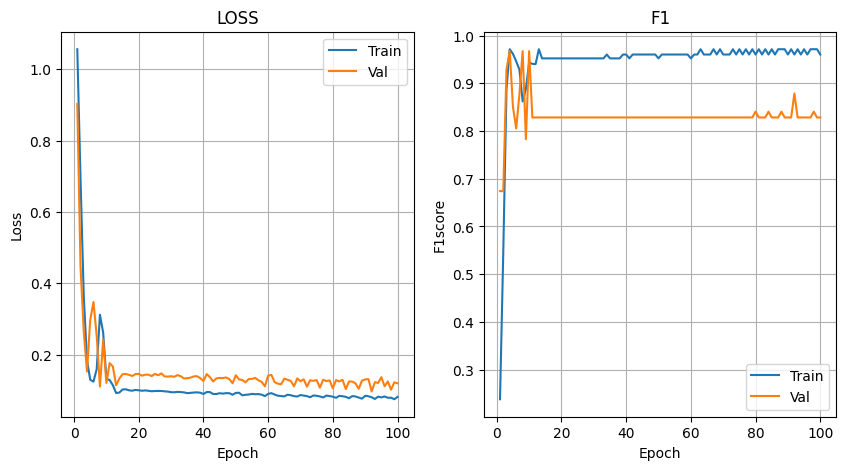

In [65]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt


fg, axes = plt.subplots(1,2 , figsize=(10,5))
axes[0].plot(range(1, 100+1), loss[0], label='Train')
axes[0].plot(range(1, 100+1), loss[1], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, 100+1), score[0], label='Train')
axes[1].plot(range(1, 100+1), score[1], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("F1score")
axes[1].set_title("F1")